## Red neuronal recurrente desde cero.

Fuente: https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

### Generamos una "serie de tiempo"

In [5]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)]) + np.random.rand(200)

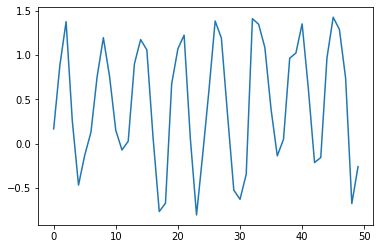

In [6]:
plt.plot(sin_wave[:50])

In [7]:
len(sin_wave), sin_wave.shape

(200, (200,))

### Guardamos algunos intervalos de tiempo X(t)

In [8]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len #150

for i in range(num_records - 50): #100
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X[i], Y[i]))
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

it: 0 | X:[ 0.16527634  0.88389972  1.37729208  0.25638029 -0.46993633 -0.13240995
  0.12701173  0.75735197  1.19620195  0.75831414  0.14885719 -0.07308023
  0.02575178  0.90069991  1.17495284  1.0589178   0.06889922 -0.7689046
 -0.67552363  0.6752345   1.07086958  1.22496778  0.05919072 -0.80733101
 -0.12002545  0.6020166   1.38483281  1.1913517   0.32037484 -0.52645435
 -0.63110563 -0.34733105  1.41083255  1.34795648  1.08525502  0.3865487
 -0.13954887  0.04715764  0.96466083  1.02275899  1.35258992  0.62029423
 -0.21539821 -0.15890349  0.96930326  1.42750777  1.29002434  0.74109132
 -0.67912284 -0.26175971] | Y:-0.1367269384913421
it: 1 | X:[ 0.88389972  1.37729208  0.25638029 -0.46993633 -0.13240995  0.12701173
  0.75735197  1.19620195  0.75831414  0.14885719 -0.07308023  0.02575178
  0.90069991  1.17495284  1.0589178   0.06889922 -0.7689046  -0.67552363
  0.6752345   1.07086958  1.22496778  0.05919072 -0.80733101 -0.12002545
  0.6020166   1.38483281  1.1913517   0.32037484 -0.5264

In [9]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

### Creamos un conjunto de validación

In [10]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    print("it: {} | X:{} | Y:{}".format(i, X_val[i-100], Y_val[i-100]))
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

it: 100 | X:[-0.31525726  1.1167324   1.83907234  1.01915263  0.13441911 -0.6730502
  0.15315192  1.13579529  1.49291183  1.5020623   0.02832369 -0.31229428
 -0.76612645  0.67481985  1.20352831  1.3754032   0.51460762 -0.28457555
 -0.12531886  0.38543409  0.89379408  1.66193226  1.05065314  0.18179577
 -0.5715754  -0.05695802  0.39789434  1.84163359  1.15916463 -0.17299347
 -0.07568617 -0.21014328  0.66367932  1.29913578  1.04596756  0.11479638
  0.16458652 -0.85648126  0.19087646  0.97343305  1.30830017  1.33945891
  0.26659687 -0.83824189 -0.28415158  0.6178281   1.61813474  0.89951176
  0.14807773 -0.38285072] | Y:-0.46221796099320867
it: 101 | X:[ 1.1167324   1.83907234  1.01915263  0.13441911 -0.6730502   0.15315192
  1.13579529  1.49291183  1.5020623   0.02832369 -0.31229428 -0.76612645
  0.67481985  1.20352831  1.3754032   0.51460762 -0.28457555 -0.12531886
  0.38543409  0.89379408  1.66193226  1.05065314  0.18179577 -0.5715754
 -0.05695802  0.39789434  1.84163359  1.15916463 -0

## Arquitectura de la RNN

In [11]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # largo de la secuencia
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

### Matrices de Pesos:

 - U es la matriz de pesos para los pesos entre la entrada y las capas ocultas.
 - V es la matriz de pesos para los pesos entre las capas ocultas y las de salida.
 - W es la matriz de pesos para los pesos compartidos en la capa oculta, la capa recurrente propia de las RNNs.

In [12]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

### Función de activación:

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Entrenamiento
```
for epocas 
    for secuence in Y
        for element in secuence
```

In [14]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    
    # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    
    # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[132811.47540148]] , Val Loss:  [[66318.43852232]]
Epoch:  2 , Loss:  [[86278.76092761]] , Val Loss:  [[43069.42063262]]
Epoch:  3 , Loss:  [[49746.04645372]] , Val Loss:  [[24820.40274291]]
Epoch:  4 , Loss:  [[23213.33318623]] , Val Loss:  [[11571.38546434]]
Epoch:  5 , Loss:  [[6711.09059235]] , Val Loss:  [[3337.72744026]]
Epoch:  6 , Loss:  [[74.19661445]] , Val Loss:  [[36.99566685]]
Epoch:  7 , Loss:  [[26.44104963]] , Val Loss:  [[15.04147904]]
Epoch:  8 , Loss:  [[26.38029747]] , Val Loss:  [[15.02167863]]
Epoch:  9 , Loss:  [[26.57412718]] , Val Loss:  [[15.16139931]]
Epoch:  10 , Loss:  [[26.97581531]] , Val Loss:  [[15.43030546]]
Epoch:  11 , Loss:  [[26.50789476]] , Val Loss:  [[15.10034913]]
Epoch:  12 , Loss:  [[26.80047591]] , Val Loss:  [[15.31151912]]
Epoch:  13 , Loss:  [[26.33961839]] , Val Loss:  [[14.9845505]]
Epoch:  14 , Loss:  [[26.88341195]] , Val Loss:  [[15.36536274]]
Epoch:  15 , Loss:  [[26.86486355]] , Val Loss:  [[15.34973592]]
Epoch:

In [15]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

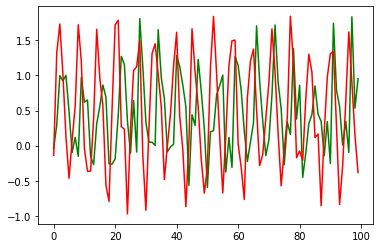

In [16]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

### Ahora en el conjunto de validación

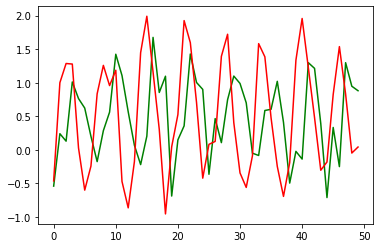

In [17]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_val[:, 0], preds[:, 0, 0])

1.0550390499721634

### Comparando con una red MLP de tensorflow

In [19]:
import tensorflow.keras as K

In [20]:
numNeurons = 100
model = K.models.Sequential([
    K.layers.Dense(numNeurons, activation='relu', input_shape=(50,)),
    K.layers.Dense(1, activation='linear')
    # 
    
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X[:,:,0],
                    Y,
                    validation_data=(X_val[:,:,0],
                                     Y_val),
                    epochs=20, batch_size=16)  

Epoch 1/20
7/7 [==============================] - 0s 14ms/step - loss: 1.2642 - val_loss: 0.3655
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.2141 - val_loss: 0.2667
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.2293 - val_loss: 0.2913
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1903 - val_loss: 0.1745
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0963 - val_loss: 0.1676
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.1093 - val_loss: 0.1879
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0973 - val_loss: 0.1556
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0789 - val_loss: 0.1540
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0741 - val_loss: 0.1600
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0714 - val_loss: 0.1593
Epoch 11/20
7/7 [=====================

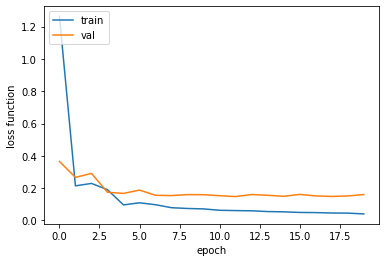

In [22]:
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
# plt.title('model loss function: {:.3} min'.format(timef))
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [23]:
preds = model.predict(X_val[:,:,0])
preds.shape, Y_val.shape, X_val[:,:,0].shape

2/2 [==============================] - 0s 1ms/step


((50, 1), (50, 1), (50, 50))

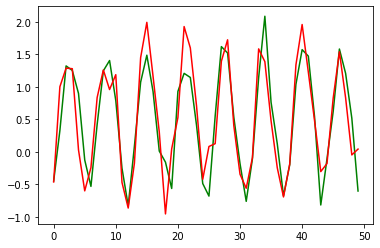

In [24]:
plt.plot(preds, 'g')
plt.plot(Y_val, 'r')
plt.show()